In [1]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import time
from datetime import datetime, date
import random

import numpy as np
from scipy.sparse import load_npz
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import pandas as pd

import torch
import torch_geometric
import torch.nn.functional as F
import torch.nn as nn

from model_classes_ import GCN_classification, GCN_regression
from baseline_mdl_classes import MLP_classification, MLP_regression

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def train_model_classification(model, graph, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer):
    '''
    Trains model for classification task
    
    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    max_epoch [int]: Maximum number of training epochs
    learning_rate [float]: Learning rate
    targetNode_mask [tensor]: Subgraph mask for training nodes
    train_idx [array]: Node IDs corresponding to training set
    valid_idx [array]: Node IDs corresponding to validation set
    optimizer [PyTorch optimizer class]: PyTorch optimization algorithm

    Returns
    -------
    train_loss_vec [array]: Training loss for each epoch
    train_AUROC_vec [array]: Training AUROC score for each epoch
    valid_loss_vec [array]: Validation loss for each epoch
    valid_AUROC_vec [array]: Validation AUROC score for each epoch

    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)

    optimizer = optimizer
    
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    
    train_loss_list = []
    train_AUROC_vec = np.zeros(np.shape(np.arange(max_epoch)))
    valid_loss_list = []
    valid_AUROC_vec = np.zeros(np.shape(np.arange(max_epoch)))

    model.train()
    train_status = True
    
    print('\n')
    for e in list(range(max_epoch)):
        
        if e%100 == 0:
            print("Epoch", str(e), 'out of', str(max_epoch))
        
        model.train()
        train_status = True
        
        optimizer.zero_grad()
        
        ### Only trains on nodes with genes due to masking
        forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]
        
        train_scores = forward_scores[train_idx]

        train_loss  = model.loss(train_scores, torch.LongTensor(train_labels).to(device))

        train_softmax, _ = model.calc_softmax_pred(train_scores)

        train_loss.backward()
        
        optimizer.step()
            
        ### Calculate training and validation loss, AUROC scores
        model.eval()
        
        valid_scores = forward_scores[valid_idx]
        valid_loss  = model.loss(valid_scores, torch.LongTensor(valid_labels).to(device))
        valid_softmax, _ = model.calc_softmax_pred(valid_scores) 

        train_loss_list.append(train_loss.item())
        train_softmax = to_cpu_npy(train_softmax)
        train_AUROC = roc_auc_score(train_labels, train_softmax[:,1], average="micro")

        valid_loss_list.append(valid_loss.item())
        valid_softmax = to_cpu_npy(valid_softmax)
        valid_AUROC = roc_auc_score(valid_labels, valid_softmax[:,1], average="micro")
        
        train_AUROC_vec[e] = train_AUROC
        valid_AUROC_vec[e] = valid_AUROC

    train_loss_vec = np.reshape(np.array(train_loss_list), (-1, 1))
    valid_loss_vec = np.reshape(np.array(valid_loss_list), (-1, 1))

    return train_loss_vec, train_AUROC_vec, valid_loss_vec, valid_AUROC_vec


def eval_model_classification(model, graph, targetNode_mask, train_idx, valid_idx, test_idx):
    '''
    Runs fully trained classification model and compute evaluation statistics

    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    targetNode_mask [tensor]: Mask ensuring model only trains on nodes with genes
    train_idx [array]: Node IDs corresponding to training set;
        analogous for valid_idx and test_idx

    Returns
    -------
    test_AUROC [float]: Test set AUROC score;
        analogous for train_AUROC (training set) and valid_AUPR (validation set)
    test_AUPR [float]: Test set AUPR score
        analogous for train_AUPR (training set) and valid_AUPR (validation set)
    test_pred [array]: Test set predictions;
        analogous for train_pred (training set) and valid_pred (validation set)
    test_labels [array]: Test set labels;
        analagous for train_labels (training set) and valid_labels (validation set)
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)
    test_labels = to_cpu_npy(graph.y[targetNode_mask[test_idx]])
    
    model.eval()
    train_status=False

    forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]

    test_scores = forward_scores[test_idx]
    test_softmax, test_pred = model.calc_softmax_pred(test_scores) 
    
    test_softmax = to_cpu_npy(test_softmax)
    test_pred = to_cpu_npy(test_pred)
    test_AUROC = roc_auc_score(test_labels, test_softmax[:,1], average="micro")
    test_precision, test_recall, thresholds = precision_recall_curve(test_labels, test_softmax[:,1])
    test_AUPR = auc(test_recall, test_precision)
    # test_F1 = f1_score(test_labels, test_pred, average="micro")
    
    train_scores = forward_scores[train_idx]
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    train_softmax, train_pred = model.calc_softmax_pred(train_scores) 
    train_pred = to_cpu_npy(train_pred)
    train_softmax = to_cpu_npy(train_softmax)
    train_precision, train_recall, thresholds = precision_recall_curve(train_labels, train_softmax[:,1])
    train_AUPR = auc(train_recall, train_precision)
    # train_F1 = f1_score(train_labels, train_pred, average="micro")

    valid_scores = forward_scores[valid_idx]
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    valid_softmax, valid_pred = model.calc_softmax_pred(valid_scores) 
    valid_pred = to_cpu_npy(valid_pred)
    valid_softmax = to_cpu_npy(valid_softmax)
    valid_precision, valid_recall, thresholds = precision_recall_curve(valid_labels, valid_softmax[:,1])
    valid_AUPR = auc(valid_recall, valid_precision)
    # valid_F1 = f1_score(valid_labels, valid_pred, average="micro")

    return test_AUROC, test_AUPR, test_pred, test_labels, train_AUPR, train_pred, train_labels, \
        valid_AUPR, valid_pred, valid_labels


def train_model_regression(model, graph, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer):
    '''
    Trains model for regression task
    
    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    max_epoch [int]: Maximum number of training epochs
    learning_rate [float]: Learning rate
    targetNode_mask [tensor]: Subgraph mask for training nodes
    train_idx [array]: Node IDs corresponding to training set
    valid_idx [array]: Node IDs corresponding to validation set
    optimizer [PyTorch optimizer class]: PyTorch optimization algorithm

    Returns
    -------
    train_loss_vec [array]: Training loss for each epoch;
        analagous for valid_loss_vec (validation set)
    train_pearson_vec [array]: Training PCC for each epoch;
        analogous for valid_pearson_vec (validation set)
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)

    optimizer = optimizer
    
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    
    train_loss_list = []
    train_pearson_vec = np.zeros(np.shape(np.arange(max_epoch)))
    valid_loss_list = []
    valid_pearson_vec = np.zeros(np.shape(np.arange(max_epoch)))

    model.train()
    train_status = True
    
    print('\n')
    for e in list(range(max_epoch)):
        
        if e%100 == 0:
            print("Epoch", str(e), 'out of', str(max_epoch))
        
        model.train()
        train_status = True
        
        optimizer.zero_grad()
        
        ### Only trains on nodes with genes due to masking
        forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]
        
        train_scores = forward_scores[train_idx]

        train_loss  = model.loss(train_scores, torch.FloatTensor(train_labels).to(device))

        train_loss.backward()
        
        optimizer.step()
            
        ### Calculate training and validation loss, AUROC scores
        model.eval()
        
        train_scores = to_cpu_npy(train_scores)
        train_pearson = calc_pearson(train_scores, train_labels)
        train_loss_list.append(train_loss.item())
        
        valid_scores = forward_scores[valid_idx]
        valid_loss  = model.loss(valid_scores, torch.FloatTensor(valid_labels).to(device))
        valid_scores = to_cpu_npy(valid_scores)
        valid_pearson  = calc_pearson(valid_scores, valid_labels)
        valid_loss_list.append(valid_loss.item())
        
        train_pearson_vec[e] = train_pearson
        valid_pearson_vec[e] = valid_pearson

    train_loss_vec = np.reshape(np.array(train_loss_list), (-1, 1))
    valid_loss_vec = np.reshape(np.array(valid_loss_list), (-1, 1))

    return train_loss_vec, train_pearson_vec, valid_loss_vec, valid_pearson_vec


def eval_model_regression(model, graph, targetNode_mask, train_idx, valid_idx, test_idx):
    '''
    Runs fully trained regression model and compute evaluation statistics

    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    targetNode_mask [tensor]: Mask ensuring model only trains on nodes with genes
    train_idx [array]: Node IDs corresponding to training set;
        analogous for valid_idx and test_idx

    Returns
    -------
    test_pearson [float]: PCC for test set;
        analogous for train_pearson (training set) and valid_pearson (validation set)
    test_pred [array]: Test set predictions;
        analogous for train_pred (training set) and valid_pred (validation set)
    test_labels [array]: Test set labels (expression values);
        analagous for train_labels (training set) and valid_labels (validation set)

    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)
    
    model.eval()
    train_status=False

    forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]

    test_scores = forward_scores[test_idx]
    test_pred = to_cpu_npy(test_scores)
    test_labels = to_cpu_npy(graph.y[targetNode_mask[test_idx]])
    test_pearson = calc_pearson(test_pred, test_labels)

    train_scores = forward_scores[train_idx]
    train_pred = to_cpu_npy(train_scores)
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    train_pearson = calc_pearson(train_pred, train_labels)

    valid_scores = forward_scores[valid_idx]
    valid_pred = to_cpu_npy(valid_scores)
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    valid_pearson = calc_pearson(valid_pred, valid_labels)

    return test_pearson, test_pred, test_labels, train_pearson, train_pred, train_labels, \
        valid_pearson, valid_pred, valid_labels
        

def calc_pearson(scores, targets):
    '''
    Calculates Pearson correlation coefficient (PCC) between predicted \
        expression levels and true expression levels

    Parameters
    ----------
    scores [array]: Predicted expression levels
    targets [array]: True expression levels

    Returns
    -------
    pcc [float]: Pearson correlation coefficient

    '''
    pcc, _ = pearsonr(scores, targets)
            
    return pcc
    
    
def to_cpu_npy(x):
    '''
    Simple helper function to transfer GPU tensors to CPU numpy matrices

    Parameters
    ----------
    x [tensor]: PyTorch tensor stored on GPU

    Returns
    -------
    new_x [array]: Numpy array stored on CPU

    '''

    new_x = x.cpu().detach().numpy()
    
    return new_x

In [4]:
cell_line = 'E116'
max_epoch = 1000
learning_rate = 1e-4
num_graph_conv_layers = 2
graph_conv_embed_size = 256
num_lin_layers = 3
lin_hidden_size = 256
regression_flag = 0
random_seed = 0

chip_res = 10000
hic_res = 10000
num_hm = 6
num_feat = int((hic_res/chip_res)*num_hm)
num_classes = 2 if regression_flag == 0 else 1

In [5]:
print('Cell line:', cell_line)
print('ChIP-seq resolution:', str(chip_res))
print('\n')
print('Training set: 70%')
print('Validation set: 15%')
print('Testing set: 15%')
print('\n')
print('Model hyperparameters: ')
print('Number of epochs:', max_epoch)
print('Learning rate:', learning_rate)
print('Number of graph convolutional layers:', str(num_graph_conv_layers))
print('Graph convolutional embedding size:', graph_conv_embed_size)
print('Number of linear layers:', str(num_lin_layers))
print('Linear hidden layer size:', lin_hidden_size)

Cell line: E116
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 1000
Learning rate: 0.0001
Number of graph convolutional layers: 2
Graph convolutional embedding size: 256
Number of linear layers: 3
Linear hidden layer size: 256


In [6]:
# random_seed = random.randint(0,10000)
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [7]:
start_time = time.time()

today = date.today()
mdy = today.strftime("%Y-%m-%d")
clock = datetime.now()
hms = clock.strftime("%H-%M-%S")
hm = clock.strftime("%Hh-%Mm")
hm_colon = clock.strftime("%H:%M")
date_and_time = mdy + '-at-' + hms


###Test for GPU availability
cuda_flag = torch.cuda.is_available()
if cuda_flag:  
  dev = "cuda" 
else:
  dev = "cpu"  
device = torch.device(dev)  


###Load input files
def prepare_data(cell_line, regression_flag):
    base_path = os.getcwd()
    save_dir = os.path.join(base_path, 'data', cell_line, 'saved_runs')
    hic_sparse_mat_file = os.path.join(base_path, 'data', cell_line, 'hic_sparse.npz')
    np_nodes_lab_genes_file = os.path.join(base_path, 'data',  cell_line, \
        'np_nodes_lab_genes_reg' + str(regression_flag) + '.npy')
    np_hmods_norm_all_file = os.path.join(base_path, 'data', cell_line, \
        'np_hmods_norm_chip_' + str(chip_res) + 'bp.npy')
    df_genes_file = os.path.join(base_path, 'data', cell_line, 'df_genes_reg' + str(regression_flag) + '.pkl')
    df_genes = pd.read_pickle(df_genes_file)
    
    mat = load_npz(hic_sparse_mat_file)
    allNodes_hms = np.load(np_hmods_norm_all_file)
    hms = allNodes_hms[:, 1:] #only includes features, not node ids
    X = torch.tensor(hms).float().reshape(-1, num_feat) 
    allNodes = allNodes_hms[:, 0].astype(int)
    geneNodes_labs = np.load(np_nodes_lab_genes_file)

    geneNodes = geneNodes_labs[:, -2].astype(int)
    allLabs = -1*np.ones(np.shape(allNodes))

    targetNode_mask = torch.tensor(geneNodes).long()

    if regression_flag == 0:
        geneLabs = geneNodes_labs[:, -1].astype(int)
        allLabs[geneNodes] = geneLabs
        Y = torch.tensor(allLabs).long()
    else:
        geneLabs = geneNodes_labs[:, -1].astype(float)
        allLabs[geneNodes] = geneLabs
        Y = torch.tensor(allLabs).float()

    extract = torch_geometric.utils.from_scipy_sparse_matrix(mat)
    data = torch_geometric.data.Data(edge_index = extract[0], edge_attr = extract[1], x = X, y = Y)
    G = data
    
    ###Randomize node order and split into 70%/15%/15% training/validation/test sets
    pred_idx_shuff = torch.randperm(targetNode_mask.shape[0])
    fin_train = np.floor(0.7*pred_idx_shuff.shape[0]).astype(int)
    fin_valid = np.floor(0.85*pred_idx_shuff.shape[0]).astype(int)
    train_idx = pred_idx_shuff[:fin_train]
    valid_idx = pred_idx_shuff[fin_train:fin_valid]
    test_idx = pred_idx_shuff[fin_valid:]
    
    return G, targetNode_mask, train_idx, valid_idx, test_idx

In [8]:
lin_hidden_sizes = [num_feat] + [int(max(lin_hidden_size, num_classes)) for i in np.arange(1, num_lin_layers, 1)] + [num_classes]

print(lin_hidden_sizes)

[6, 256, 256, 2]


In [9]:
G, targetNode_mask, train_idx, valid_idx, test_idx = prepare_data(cell_line='E116', regression_flag = regression_flag)

In [10]:
model = MLP_classification(num_feat, num_lin_layers, lin_hidden_sizes, num_classes)

optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), 
                            lr = learning_rate)

print("\n"+"Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
lin1.weight 	 torch.Size([256, 6])
lin1.bias 	 torch.Size([256])
lin2.weight 	 torch.Size([256, 256])
lin2.bias 	 torch.Size([256])
lin3.weight 	 torch.Size([2, 256])
lin3.bias 	 torch.Size([2])


In [11]:
### Train model
train_loss_vec, train_AUROC_vec, valid_loss_vec, valid_AUROC_vec = \
    train_model_classification(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)

### Evaluate model
test_AUROC, test_AUPR, test_pred, test_labels, train_AUPR, train_pred, train_labels, \
        valid_AUPR, valid_pred, valid_labels = \
            eval_model_classification(model, G, targetNode_mask, train_idx, valid_idx, test_idx)



Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000


In [12]:
print(f'Classification Performance for {cell_line}:\n')
print('Test AUROC:', test_AUROC, '\n')
print('Test AUPR:', test_AUPR, '\n\n')

Classification Performance for E116:

Test AUROC: 0.9089170413484439 

Test AUPR: 0.8893641635855877 




In [13]:
num_classes_reg = 1
G, targetNode_mask, train_idx, valid_idx, test_idx = prepare_data(cell_line='E116', regression_flag = 1)
lin_hidden_sizes_reg = [num_feat] + [int(max(lin_hidden_size, num_classes_reg)) for i in np.arange(1, num_lin_layers, 1)] + [num_classes_reg]


model = MLP_regression(num_feat, num_lin_layers, lin_hidden_sizes_reg, num_classes=1)

optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), 
                            lr = learning_rate)

print("\n"+"Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
lin1.weight 	 torch.Size([256, 6])
lin1.bias 	 torch.Size([256])
lin2.weight 	 torch.Size([256, 256])
lin2.bias 	 torch.Size([256])
lin3.weight 	 torch.Size([1, 256])
lin3.bias 	 torch.Size([1])


In [14]:
train_loss_vec, train_pearson_vec, valid_loss_vec, valid_pearson_vec = \
        train_model_regression(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)
    
test_pearson, test_pred, test_labels, train_pearson, train_pred, train_labels, \
        valid_pearson, valid_pred, valid_labels = \
            eval_model_regression(model, G, targetNode_mask, train_idx, valid_idx, test_idx)



Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000


In [15]:
print(f'Regression Performance for {cell_line}:\n')
print('Test Pearson:', test_pearson, '\n')

Regression Performance for E116:

Test Pearson: 0.7720279964982971 



In [23]:
graph_conv_embed_size = 256
num_graph_conv_layers = 2

graph_conv_layer_sizes = [num_feat] + \
    [int(max(graph_conv_embed_size, lin_hidden_size)) \
          for i in np.arange(1, num_graph_conv_layers, 1)] + [lin_hidden_size]

graph_lin_hidden_sizes = [graph_conv_layer_sizes[-1]] + \
    [int(max(lin_hidden_size, num_classes)) \
          for i in np.arange(1, num_lin_layers, 1)] + [num_classes]

In [17]:
cell_lines = ['E116', 'E122', 'E123']
classification_res = pd.DataFrame(columns=cell_lines)

In [18]:
gcn_auroc = []
for cell_line in cell_lines:
    print(f'\nTraining Cell Line {cell_line}...')
    G, targetNode_mask, train_idx, valid_idx, test_idx = prepare_data(cell_line=cell_line, regression_flag = regression_flag)
    
    model = GCN_classification(num_feat, num_graph_conv_layers, graph_conv_layer_sizes, num_lin_layers, graph_lin_hidden_sizes, num_classes)
    optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = learning_rate)
    
    train_loss_vec, train_AUROC_vec, valid_loss_vec, valid_AUROC_vec = \
    train_model_classification(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)

    test_AUROC, test_AUPR, test_pred, test_labels, train_AUPR, train_pred, train_labels, \
        valid_AUPR, valid_pred, valid_labels = \
            eval_model_classification(model, G, targetNode_mask, train_idx, valid_idx, test_idx)
    
    gcn_auroc.append(test_AUROC)
    
classification_res.loc['GCN'] = gcn_auroc
classification_res


Training Cell Line E116...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E122...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E123...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000


,E116,E122,E123
GCN,0.915148,0.908606,0.923687


In [19]:
mlp_auroc = []

for cell_line in ['E116', 'E122', 'E123']:
    print(f'\nTraining Cell Line {cell_line}...')
    G, targetNode_mask, train_idx, valid_idx, test_idx = prepare_data(cell_line=cell_line, regression_flag = regression_flag)
    
    model = MLP_classification(num_feat, num_lin_layers, lin_hidden_sizes, num_classes)
    optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = learning_rate)
    
    train_loss_vec, train_AUROC_vec, valid_loss_vec, valid_AUROC_vec = \
    train_model_classification(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)

    test_AUROC, test_AUPR, test_pred, test_labels, train_AUPR, train_pred, train_labels, \
        valid_AUPR, valid_pred, valid_labels = \
            eval_model_classification(model, G, targetNode_mask, train_idx, valid_idx, test_idx)
    
    mlp_auroc.append(test_AUROC)
    
classification_res.loc['MLP'] = mlp_auroc
classification_res


Training Cell Line E116...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E122...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E123...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000


,E116,E122,E123
GCN,0.915148,0.908606,0.923687
MLP,0.907612,0.890965,0.913425


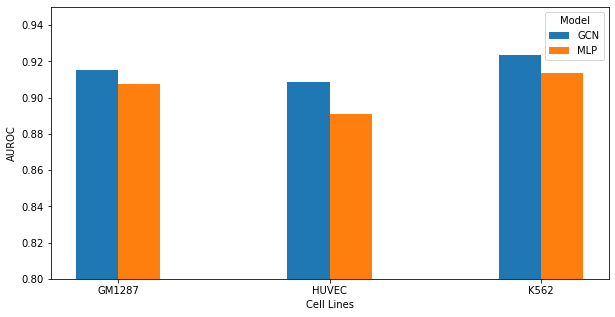

In [20]:
import matplotlib.pyplot as plt

cell_line_alias = {'E116': 'GM1287', 'E123': 'K562', 'E122': 'HUVEC'}

fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2
index = np.arange(len(classification_res.columns))

# Plot each model's scores as a separate set of bars
for i, model in enumerate(classification_res.index):
    ax.bar(index + i * bar_width, classification_res.loc[model], bar_width, label=model)

# Add labels, title, and legend
ax.set_xlabel('Cell Lines')
ax.set_ylabel('AUROC')
ax.set_xticks(index + bar_width * (len(classification_res.index) - 1) / 2)
ax.set_ylim(0.8, 0.95)
ax.set_xticklabels([cell_line_alias[cell_line] for cell_line in classification_res.columns] )
ax.legend(title='Model')

plt.show()

In [21]:
regression_res = pd.DataFrame(columns=cell_lines)

In [24]:
gcn_pearson = []
graph_lin_hidden_sizes[-1] -= 1
for cell_line in cell_lines:
    print(f'\nTraining Cell Line {cell_line}...')
    G, targetNode_mask, train_idx, valid_idx, test_idx = prepare_data(cell_line=cell_line, regression_flag = 1)
    
    model = GCN_regression(num_feat, num_graph_conv_layers, graph_conv_layer_sizes, num_lin_layers, graph_lin_hidden_sizes, num_classes_reg)
    optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = learning_rate)
    
    train_loss_vec, train_pearson_vec, valid_loss_vec, valid_pearson_vec = \
        train_model_regression(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)
    
    test_pearson, test_pred, test_labels, train_pearson, train_pred, train_labels, \
        valid_pearson, valid_pred, valid_labels = \
            eval_model_regression(model, G, targetNode_mask, train_idx, valid_idx, test_idx)
    
    gcn_pearson.append(test_pearson)
    
regression_res.loc['GCN'] = gcn_pearson
regression_res


Training Cell Line E116...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E122...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E123...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000


,E116,E122,E123
GCN,0.784386,0.75781,0.81092


In [25]:
mlp_pearson = []

for cell_line in ['E116', 'E122', 'E123']:
    print(f'\nTraining Cell Line {cell_line}...')
    G, targetNode_mask, train_idx, valid_idx, test_idx = prepare_data(cell_line=cell_line, regression_flag = 1)
    
    model = MLP_regression(num_feat, num_lin_layers, lin_hidden_sizes_reg, num_classes_reg)
    optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = learning_rate)
    
    train_loss_vec, train_pearson_vec, valid_loss_vec, valid_pearson_vec = \
        train_model_regression(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)
    
    test_pearson, test_pred, test_labels, train_pearson, train_pred, train_labels, \
        valid_pearson, valid_pred, valid_labels = \
            eval_model_regression(model, G, targetNode_mask, train_idx, valid_idx, test_idx)
    
    mlp_pearson.append(test_pearson)
    
regression_res.loc['MLP'] = mlp_pearson
regression_res


Training Cell Line E116...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E122...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E123...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000


,E116,E122,E123
GCN,0.784386,0.757810,0.810920
MLP,0.759594,0.728012,0.798564


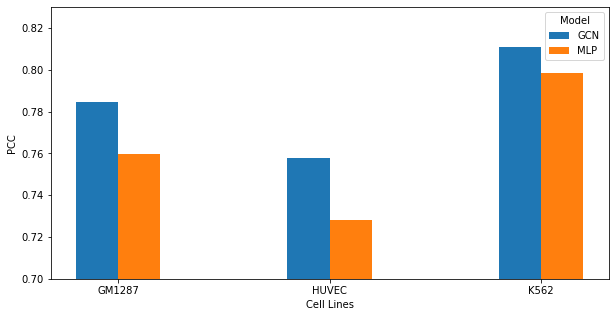

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2
index = np.arange(len(regression_res.columns))

# Plot each model's scores as a separate set of bars
for i, model in enumerate(regression_res.index):
    ax.bar(index + i * bar_width, regression_res.loc[model], bar_width, label=model)

# Add labels, title, and legend
ax.set_xlabel('Cell Lines')
ax.set_ylabel('PCC')
ax.set_xticks(index + bar_width * (len(regression_res.index) - 1) / 2)
ax.set_ylim(0.7, 0.83)
ax.set_xticklabels([cell_line_alias[cell_line] for cell_line in regression_res.columns] )
ax.legend(title='Model')

plt.show()

In [31]:
test_pred, test_labels

(array([0.1354717 , 0.00569321, 0.35021168, ..., 1.5256953 , 1.0082436 ,
        1.1523998 ], dtype=float32),
 array([0.        , 0.        , 0.00216606, ..., 1.7453625 , 1.6119038 ,
        1.3987904 ], dtype=float32))

/tmp/ipykernel_151/2031889.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(test_labels), -np.log10(test_pred))
/tmp/ipykernel_151/2031889.py:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter(-np.log10(test_labels), -np.log10(test_pred))


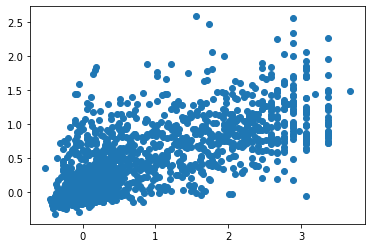

In [33]:
plt.scatter(-np.log10(test_labels), -np.log10(test_pred))